In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy import interpolate

def show_data(data,fit_info = (False,None,False,None),filename='',show = False,mag_only = True):
    if show:
        if mag_only:
            fig1 = plt.figure(constrained_layout = True)
            ax = fig1.add_subplot(1, 1, 1)
            ax.scatter(data['freq'],data['vmag']*data['vamp'],color='green',label=filename)
            if fit_info[0]:
                bestpars1 = fit_info[1]
                ax.plot(data['freq'],data['vamp']*full_lorenzian_fit_with_skew(data['freq'],*bestpars1),label='Full Lorenzian Fit')
                
            if fit_info[2]:
                bestpars2 = fit_info[3]
                ax.plot(data['freq'],data['vamp']*simple_lorenzian_fit(data['freq'],*bestpars2),label = 'Refined Fit')
            ax.legend()  
            ax.set_xlabel('Frequency (kHz)')
            ax.set_ylabel('Voltage Magnitude (mV)')
            ax.set_title('Lorenzian Fit for '+filename)
        else:
            fig0 = plt.figure(constrained_layout = True)
            ax1 = fig0.add_subplot(3, 1, 1)
            ax2 = fig0.add_subplot(3, 1, 2)
            ax3 = fig0.add_subplot(3, 1, 3)
            ax1.set_xlabel('Frequency (kHz)')
            ax2.set_xlabel('Frequency (kHz)')
            ax3.set_xlabel('Frequency (kHz)')
            ax1.set_ylabel('Vx (mV)')
            ax2.set_ylabel('Vx (mV)')
            ax3.set_ylabel('Voltage Magnitude (mV)')
            ax1.plot(data['freq'],data['vx'])
            ax2.plot(data['freq'],data['vy'])
            ax3.plot(data['freq'],data['vmag']*data['vamp'])

def cosort_lists(list_to_sort,list_to_cosort):
    out1 = np.zeros(l1 := len(list_to_sort))
    out2 = np.zeros(len(list_to_cosort))
    sorted_inds = np.argsort(np.argsort(list_to_sort))
    for i in range(l1):
        for j, ind in enumerate(sorted_inds):
            if i == ind:
                out1[i] = list_to_sort[j]
                out2[i] = list_to_cosort[j]
                break
    return out1, out2

def calc_mu(omega,sigma_x,sigma_y,length=2e-3,width=1e-3,tolerance = 1e-4):
    mu_0 = 4*np.pi*1e-7
    if width>length:
        b = length/2
        a = width/2
    else:
        a = length/2
        b = width/2
    total_sum = 0
    m = 1
    change = np.inf
    alpha_m_coef = np.pi/2/a
    gamma_m_coef = np.pi/2/b
    while np.abs(change)>tolerance:
        alpha_m = m * alpha_m_coef
        gamma_m = m * gamma_m_coef
        beta_m = np.sqrt(1j*omega*mu_0*sigma_x+alpha_m**2*sigma_x/sigma_y)
        delta_m = np.sqrt(1j*omega*mu_0*sigma_y+gamma_m**2*sigma_y/sigma_x)
        change = (np.tanh(beta_m*b)/(alpha_m*beta_m)+np.tanh(delta_m*a)/(gamma_m*delta_m))/m
        total_sum += change
        m+=2
    return total_sum*4/np.pi

def calc_power(omega,sigma_x,sigma_y,H_0,length=2e-3,width=1e-3,N_m=1,tolerance = 1e-4):
    mu = calc_mu(omega,sigma_x,sigma_y,length=length,width=width,tolerance = tolerance)
    return 1j*.5*omega*4*np.pi*1e-7*H_0*mu/(1+N_m*(mu-1))

def full_Z(omega, C1, C2, L, R):
    A = (1-L*C2*omega**2)**2 + (R*C2*omega)**2
    B = L-(R**2*C2)-(C2*(L*omega)**2)
    return R/A +1j*(omega*B/A-1/(omega*C1))

def reflection_coeff(omega, C1, C2, L, R, Z0=50):
    ZL = full_Z(omega, C1, C2,L,R)
    return (ZL/Z0-1)/(ZL/Z0+1)

def full_lorenzian_fit_with_skew(fs, f0,Q,Smax,A1,A2,A3):#fs is the data, f0 is the resonance freq
    return A1 + A2*fs + (Smax+A3*fs)/np.sqrt(1+4*(Q*(fs/f0-1))**2)#this is eq 10 from Measurement of resonant frequency and quality factor of microwave resonators: Comparison of methods Paul J. Petersan; Steven M. Anlage

def simple_lorenzian_fit(fs, f0,Q,Smax,A1):
    return A1 + Smax/np.sqrt(1+4*(Q*(fs/f0-1))**2)

def plot_polyfit(x_data,poly_coefficents):
    l = len(x_data)
    output = np.zeros(l)
    for i,a in enumerate(poly_coefficents[::-1]):
        for j in range(l):
            output[j] += a*x_data[j]**i 
    return output

def VxVyfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_2ndorderbackground2(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2, D):
    complex_ref_coef = D*reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_nobackground(omega, C1, C2, L, R,):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def quad(freq,A0,A1,A2):
    return A0 + A1*freq + A2*freq**2

def Vmagfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, D):
    return D * np.abs(reflection_coeff(omega, C1, C2, L, R)) +A0 +A1*omega+A2*omega**2


Open File(s)

In [3]:

path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/'
path_suffix = '.dat'

# filenames = [
#              'double1nf',
#             #  'double.47nf',
#             #  'double3.9nf',
#             #  '.5nfseries1nfparallel',
#             #  '2nfserise1nfparallel2',
#             #  '1nfseries3.9nfparallel'
#               ]
 

# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/InitialRandomTesting/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/LChange/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/TurnTesting/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/AfterCircCalData/'
path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/AfterCircCalData/ColdTest/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/BackgroundTest/'
# path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/QFactorTesting/0.2nf1nFTest/'
filenames = os.listdir(path_prefix)
path_suffix = ''

data_paths = []
for f in filenames:
         data_paths.append(path_prefix + f + path_suffix)
         
datas = []
i = 0
for data in data_paths:
    try:
        all_data = np.genfromtxt(data, delimiter='\t')
        headings = np.genfromtxt(data, delimiter='\t', dtype=str, max_rows=1)
        datas.append({})
        # print(all_data)
        datas[i]['time'] = np.array(all_data[2:,0])
        datas[i]['vamp'] = float(headings[-1].split(' ')[-2])
        datas[i]['vx'] = np.array(all_data[2:,1])*-1000
        datas[i]['vy'] = np.array(all_data[2:,2])*-1000
        datas[i]['vmag'] = np.array(all_data[2:,3])*1000/datas[i]['vamp']
        datas[i]['freq'] = np.array(all_data[2:,4])
        # datas[i]['turns'] = float(filenames[i][:-9])
        i+=1
    except PermissionError:
        print("Can't read folder",data)


Lorenzian Fit

[(2192238.208297936, 7.6671799791971), (2999999.9999999995, 21.799383235887525), (3071112.7145755584, 15.898630422311863), (3060367.705226533, 18.036203371853546), (3042266.1472760243, 18.507062272531265), (3099709.441388523, 17.14056656534892), (3075040.6028147736, 17.62510746817526), (3047987.2885667295, 18.291115212047927), (3050119.736009146, 18.180377067813925)]
[(2199999.9999797945, 17.33722941459836), (2851453.005256082, 2.5626682648069994), (3083795.1664096424, 19.05255786231911), (2928542.5672481526, 57.15570475408342), (2806625.0182619644, 1.6443524292368044), (2805165.0163928107, 1.2955253600047487), (2942264.227682374, 58.16769021364422), (2916349.4186046445, 58.11162355916277), (2918050.756886465, 59.323181884161734)]


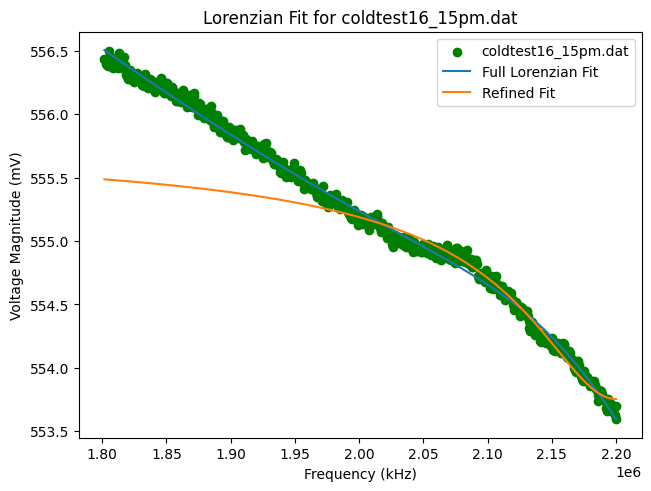

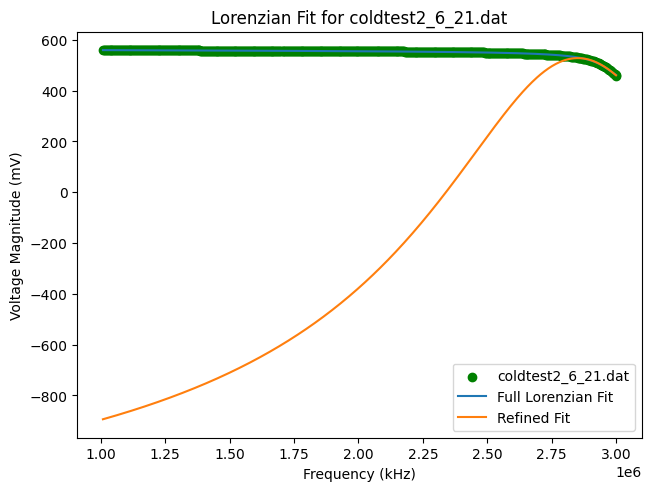

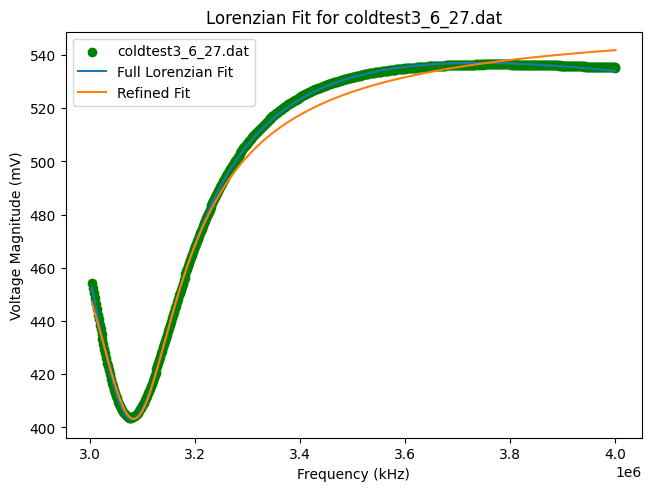

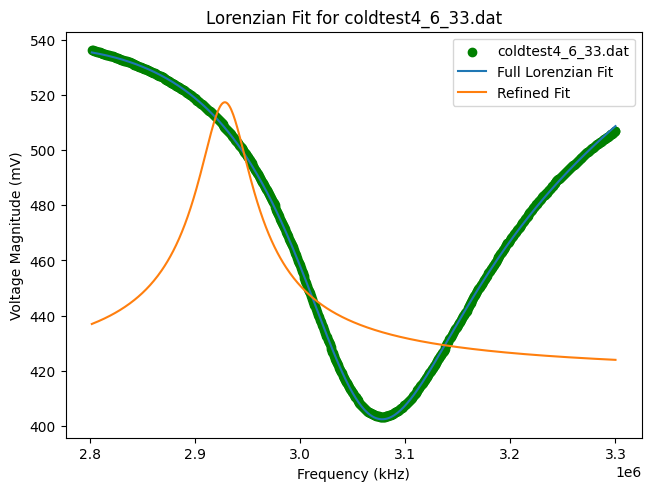

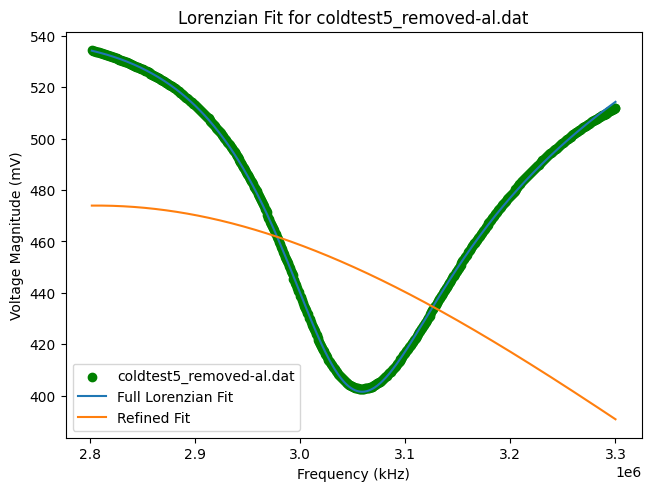

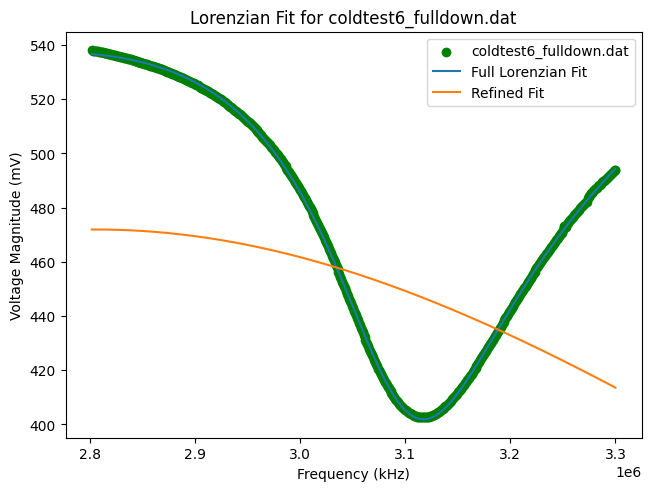

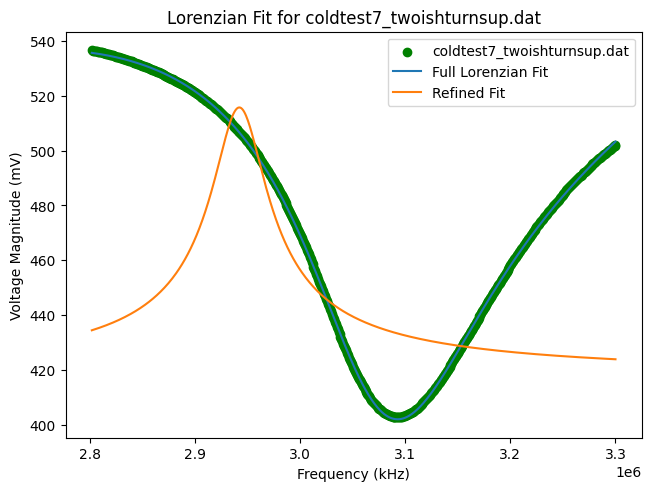

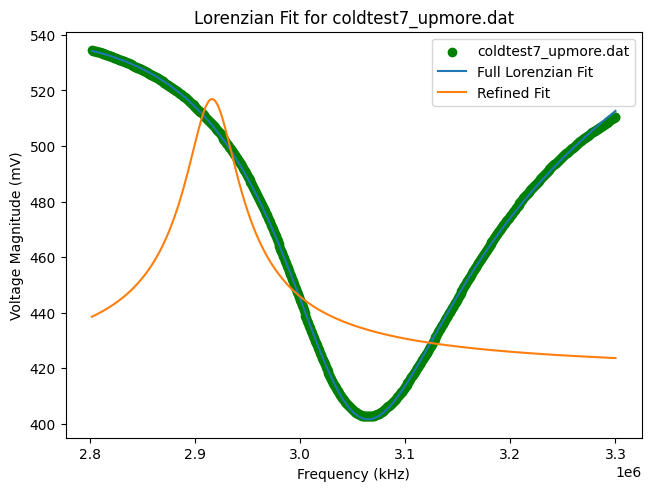

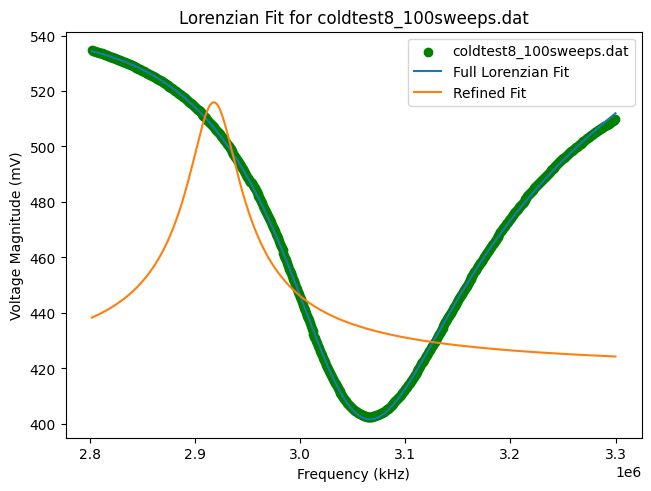

In [4]:
fits = []
fits2 = []
for i in range(len(datas)):
    res_freq_ind = np.argmin(datas[i]['vmag'])#just a guess
    f_guess = datas[i]['freq'][res_freq_ind]

    guesses1 = [f_guess,10,-.3,.26,0,0]
    pbounds1 = np.array([[max(min(datas[i]['freq']),500e3),1,-1,-1,-1,-1],[min(max(datas[i]['freq']),4000e3),1e4,1,1,1,1]]) # [[Lower bounds],[upper bounds]]
    bestfit = optimize.curve_fit(full_lorenzian_fit_with_skew,datas[i]['freq'],datas[i]['vmag'],guesses1, bounds=pbounds1)
    bestpars1 = bestfit[0]
    inds = np.logical_not(abs(datas[i]['freq']-bestpars1[0])/bestpars1[0]>.05)
    bestfit = optimize.curve_fit(simple_lorenzian_fit,datas[i]['freq'][inds],datas[i]['vmag'][inds],bestpars1[:4], bounds=[pbounds1[0][:4],pbounds1[1][:4]])
    bestpars2 = bestfit[0]
    fits.append((bestpars1[0],bestpars1[1]))
    fits2.append((bestpars2[0],bestpars2[1]))
    show_data(datas[i],fit_info = (True,bestpars1,True,bestpars2),filename=filenames[i],show = True, mag_only = True)
    fit_res_freq_ind = np.argmin(datas[i]['freq']-bestpars2[0])
print(fits)
print(fits2)

Circuit Fitting

In [5]:
ind = 2


#bounds
circ_low_bounds = [1e-12,1e-12,100e-9,1]
circ_high_bounds = [10e-9,10e-9,1e-4,1e2]
background_low_bounds = [-1e1,-1e-3,-1e-8,-1e1,-1e-3,-1e-8,1e-1]
background_high_bounds = [1e1,1e-3,1e-8,1e1,1e-3,1e-8,1]

low_bounds = np.append(circ_low_bounds,background_low_bounds)
high_bounds = np.append(circ_high_bounds,background_high_bounds)
bounds = [low_bounds,high_bounds]



#prefit

# show_data(datas[ind],fit_info = (False,bestpars1,False,bestpars2),filename='',show = True, mag_only = False) #shows where the peak is

res_peak = 2e6
peak_width = .4e6

fitted = {}
for dat in datas[ind]:
    if dat != 'vamp':
        fitted[dat] = datas[ind][dat][np.logical_or(datas[ind]['freq']<res_peak-peak_width/2, datas[ind]['freq']>res_peak+peak_width/2)]
    else:
        fitted[dat] = datas[ind][dat]
prefit_bounds = [background_low_bounds[:3],background_high_bounds[:3]]

reflect_scalar = .2
circ_guesses = [39e-12,219e-12,25e-6,13] #C_par,C_ser,L,R
circ_contrib = reflect_scalar*reflection_coeff(fitted['freq']*2*np.pi,*circ_guesses)



#guesses with prefit
vx_prefit = optimize.curve_fit(quad,fitted['freq']*2*np.pi, fitted['vx']/datas[ind]['vamp']-np.real(circ_contrib),bounds=prefit_bounds)
vy_prefit = optimize.curve_fit(quad,fitted['freq']*2*np.pi, fitted['vy']/datas[ind]['vamp']-np.imag(circ_contrib),bounds=prefit_bounds)
vx_background_guesses = vx_prefit[0]
vy_background_guesses = np.append(vy_prefit[0], [reflect_scalar])

guesses = np.append(circ_guesses,np.append(vx_background_guesses,vy_background_guesses))
guess_fit = VxVyfit_2ndorderbackground2(datas[ind]['freq']*2*np.pi,*guesses)
l = len(datas[ind]['freq'])*2
vx_guess = guess_fit[:l//2]
_ = vy_guess = guess_fit[l//2:l]




fitting_range = (1.5e6,2.5e6)
zoomed_inds = np.logical_and(datas[ind]['freq']>fitting_range[0],datas[ind]['freq']<fitting_range[1])

#use sharpest points as lowest uncertainty points
# grad_x = np.abs(np.gradient(datas[ind]['vx']))
# grad_y = np.abs(np.gradient(datas[ind]['vy']))
# error_approx = np.append(np.max(grad_x)-grad_x,np.max(grad_y)-grad_y)

x_diff = np.abs(vx_guess[zoomed_inds]-datas[ind]['vx'][zoomed_inds]/datas[ind]['vamp'])
y_diff = np.abs(vy_guess[zoomed_inds]-datas[ind]['vy'][zoomed_inds]/datas[ind]['vamp'])
# error_approx = x_diff+y_diff
# error_approx = np.append(np.max(x_diff)-x_diff,np.max(y_diff)-y_diff)*100
error_approx =np.append(np.exp(np.max(x_diff)-x_diff),np.exp(np.max(y_diff)-y_diff))
# for i in range(len(error_approx)):
#     if error_approx[i] <= 0:
#         error_approx[i] = error_approx[i-1]


# error_approx = np.ones(2*len(datas[ind]['freq']))

# def custom_error(input, res_peak,peak_width,ratio):
#     l = len(input)
#     output = np.zeros(l)
#     for i, freq in enumerate(input):
#         if abs(freq-res_peak)<peak_width//2:
#             output[i] = ratio
#         else:
#             output[i] = 1
#     return np.append(output,output)
# error_approx = custom_error(datas[ind]['freq'],res_peak,peak_width,5)
        
# print(bounds)
#choke bounds
percent = .25
for i in range(2):
    for j in range(4):
        bounds[i][j] = guesses[j]*(1-(-1)**i*percent)
# print(bounds)
#fit
bestfit = optimize.curve_fit(VxVyfit_2ndorderbackground2, datas[ind]['freq'][zoomed_inds]*2*np.pi, 
    np.append(datas[ind]['vx'][zoomed_inds]/datas[ind]['vamp'],datas[ind]['vy'][zoomed_inds]/datas[ind]['vamp']), 
    guesses, error_approx, bounds=bounds, maxfev=10000)
bestpars = bestfit[0]



# calc stuff for plotting
fit_info = VxVyfit_2ndorderbackground2(datas[ind]['freq']*2*np.pi,*bestpars)
l = len(fit_info)
vx_fit = fit_info[:l//2]
vy_fit = fit_info[l//2:l]



# no_circ = np.append([np.inf,0,0,0],bestpars[4:])
# sub_2nd_order = VxVyfit_2ndorderbackground(datas[ind]['freq']*2*np.pi,*no_circ)
# vy_nocirc = sub_2nd_order[l//2:l]
# vx_nocirc = sub_2nd_order[:l//2]



#Circuit Fit Plotting

fig4 = plt.figure(constrained_layout = True)
ax1 = fig4.add_subplot(3, 1, 1)
ax2 = fig4.add_subplot(3, 1, 2)
ax3 = fig4.add_subplot(3, 1, 3)
# ax1 = fig4.add_subplot(2, 1, 1)
# ax2 = fig4.add_subplot(2, 1, 2)
ax1.set_xlabel('Frequency (kHz)')
ax2.set_xlabel('Frequency (kHz)')
# ax3.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Vx (mV)')
ax2.set_ylabel('Vx (mV)')
# ax3.set_ylabel('Voltage Magnitude (mV)')
ax1.scatter(datas[ind]['freq'],datas[ind]['vx']/datas[ind]['vamp'])
ax2.scatter(datas[ind]['freq'],datas[ind]['vy']/datas[ind]['vamp'])
# ax3.scatter(datas[ind]['freq'],datas[ind]['vmag']*datas[ind]['vamp'])
ax1.plot(datas[ind]['freq'],vx_fit,c='green')
ax2.plot(datas[ind]['freq'],vy_fit,c='green')
ax1.plot(datas[ind]['freq'],vx_guess,c='red')
ax2.plot(datas[ind]['freq'],vy_guess,c='red')

ax1.set_xlim(1.5e6,2.5e6)
ax2.set_xlim(1.5e6,2.5e6)
ax1.set_ylim(.20,.28)
ax2.set_ylim(-.15,-.09)

# ax1.plot(datas[ind]['freq'],10*(vx_guess-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='black')
# ax2.plot(datas[ind]['freq'],10*(vy_guess-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='black')
# ax2.plot(datas[ind]['freq'],(vy_fit-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='purple')
# ax1.plot(datas[ind]['freq'],(vx_fit-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='purple')
# ax1.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vx_background_guesses),c='orange')
# ax2.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vy_background_guesses[:3]),c='orange')

#random auxiliary plotting
# ax3.plot(datas[ind]['freq'],error_approx[:l//2],label = 'x_weights')
# ax3.plot(datas[ind]['freq'],error_approx[l//2:l],label = 'y_weights')
ax3.set_xlabel('Freq')
ax3.set_ylabel('Fitting Weight')
l = len(error_approx)
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[:l//2],label = 'x_weights')
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[l//2:l],label = 'y_weights')
# ax3.plot(datas[ind]['freq'][zoomed_inds],x_diff,label = 'x_diffs')
# ax3.plot(datas[ind]['freq'][zoomed_inds],y_diff,label = 'y_diffss')
# ax3.plot(fitted['freq'],np.real(circ_contrib),label = 'x_circ-1')
# ax3.plot(fitted['freq'],np.imag(circ_contrib),label = 'y_circ')
# ax3.plot(fitted['freq'],fitted['vx']/datas[ind]['vamp']+np.real(circ_contrib),label = 'vx')
# ax3.plot(fitted['freq'],fitted['vy']/datas[ind]['vamp']+np.imag(circ_contrib),label = 'vy')
ax3.legend()
# ax3.plot(datas[ind]['freq'],vx_nocirc)
# ax3.plot(datas[ind]['freq'],vy_nocirc)
# ax3.plot(datas[ind]['freq'],np.real(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# ax3.plot(datas[ind]['freq'],np.imag(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# print(vx_nocirc)

_ = 1
print((bestpars-guesses)/guesses)
print(bestpars)

ValueError: zero-size array to reduction operation maximum which has no identity

Magnitude fitting

In [ ]:
ind = 2


#bounds
circ_low_bounds = [1e-12,1e-12,100e-9,1]
circ_high_bounds = [10e-9,10e-9,1e-4,1e2]
background_low_bounds = [-1e1,-1e-3,-1e-8,1e-1]
background_high_bounds = [1e1,1e-3,1e-8,1]

low_bounds = np.append(circ_low_bounds,background_low_bounds)
high_bounds = np.append(circ_high_bounds,background_high_bounds)
bounds = [low_bounds,high_bounds]



#prefit

# show_data(datas[ind],fit_info = (False,bestpars1,False,bestpars2),filename='',show = True, mag_only = False) #shows where the peak is

res_peak = 2e6
peak_width = .4e6

fitted = {}
for dat in datas[ind]:
    if dat != 'vamp':
        fitted[dat] = datas[ind][dat][np.logical_or(datas[ind]['freq']<res_peak-peak_width/2, datas[ind]['freq']>res_peak+peak_width/2)]
    else:
        fitted[dat] = datas[ind][dat]
prefit_bounds = [background_low_bounds[:3],background_high_bounds[:3]]

reflect_scalar = .2
circ_guesses = [39e-12,219e-12,25e-6,13] #C_par,C_ser,L,R
circ_contrib = reflect_scalar*reflection_coeff(fitted['freq']*2*np.pi,*circ_guesses)



#guesses with prefit
vmag_prefit = optimize.curve_fit(quad,fitted['freq']*2*np.pi, fitted['vmag']/datas[ind]['vamp']-np.abs(circ_contrib),bounds=prefit_bounds)
vmag_background_guesses = np.append(vmag_prefit[0], [reflect_scalar])

guesses = np.append(circ_guesses,vmag_background_guesses)
guess_fit = Vmagfit_2ndorderbackground(datas[ind]['freq']*2*np.pi,*guesses)


#use sharpest points as lowest uncertainty points
# grad_x = np.abs(np.gradient(datas[ind]['vx']))
# grad_y = np.abs(np.gradient(datas[ind]['vy']))
# error_approx = np.append(np.max(grad_x)-grad_x,np.max(grad_y)-grad_y)

# x_diff = np.abs(vx_guess-datas[ind]['vx']/datas[ind]['vamp'])
# y_diff = np.abs(vy_guess-datas[ind]['vy']/datas[ind]['vamp'])
# error_approx = np.append(np.max(x_diff)-x_diff,np.max(y_diff)-y_diff)*10000
# for i in range(len(error_approx)):
#     if error_approx[i] <= 0:
#         error_approx[i] = error_approx[i-1]
# error_approx = np.ones(2*len(datas[ind]['freq']))

# def custom_error(input, res_peak,peak_width,ratio):
#     l = len(input)
#     output = np.zeros(l)
#     for i, freq in enumerate(input):
#         if abs(freq-res_peak)<peak_width//2:
#             output[i] = ratio
#         else:
#             output[i] = 1
#     return np.append(output,output)
# error_approx = custom_error(datas[ind]['freq'],res_peak,peak_width,5)
        
# print(bounds)
# #choke bounds
# percent = .25
# for i in range(2):
#     for j in range(4):
#         bounds[i][j] = guesses[j]*(1-(-1)**i*percent)
# print(bounds)
#fit
fitting_range = (1.5e6,2.5e6)
zoomed_inds = np.logical_and(datas[ind]['freq']>fitting_range[0],datas[ind]['freq']<fitting_range[1])
bestfit = optimize.curve_fit(Vmagfit_2ndorderbackground, datas[ind]['freq'][zoomed_inds]*2*np.pi, 
    datas[ind]['vmag'][zoomed_inds]/datas[ind]['vamp'], guesses,  bounds=bounds, maxfev=10000)
bestpars = bestfit[0]



# calc stuff for plotting
fit_info = VxVyfit_2ndorderbackground2(datas[ind]['freq']*2*np.pi,*bestpars)
l = len(fit_info)
vx_fit = fit_info[:l//2]
vy_fit = fit_info[l//2:l]



# no_circ = np.append([np.inf,0,0,0],bestpars[4:])
# sub_2nd_order = VxVyfit_2ndorderbackground(datas[ind]['freq']*2*np.pi,*no_circ)
# vy_nocirc = sub_2nd_order[l//2:l]
# vx_nocirc = sub_2nd_order[:l//2]



#Circuit Fit Plotting

fig4 = plt.figure(constrained_layout = True)
ax1 = fig4.add_subplot(3, 1, 1)
ax2 = fig4.add_subplot(3, 1, 2)
ax3 = fig4.add_subplot(3, 1, 3)
# ax1 = fig4.add_subplot(2, 1, 1)
# ax2 = fig4.add_subplot(2, 1, 2)
ax1.set_xlabel('Frequency (kHz)')
ax2.set_xlabel('Frequency (kHz)')
# ax3.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Vx (mV)')
ax2.set_ylabel('Vx (mV)')
# ax3.set_ylabel('Voltage Magnitude (mV)')
ax1.scatter(datas[ind]['freq'],datas[ind]['vx']/datas[ind]['vamp'])
ax2.scatter(datas[ind]['freq'],datas[ind]['vy']/datas[ind]['vamp'])
# ax3.scatter(datas[ind]['freq'],datas[ind]['vmag']*datas[ind]['vamp'])
ax1.plot(datas[ind]['freq'],vx_fit,c='green')
ax2.plot(datas[ind]['freq'],vy_fit,c='green')
ax1.plot(datas[ind]['freq'],vx_guess,c='red')
ax2.plot(datas[ind]['freq'],vy_guess,c='red')

ax1.set_xlim(1.5e6,2.5e6)
ax2.set_xlim(1.5e6,2.5e6)
ax1.set_ylim(.20,.28)
ax2.set_ylim(-.15,-.09)

# ax1.plot(datas[ind]['freq'],10*(vx_guess-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='black')
# ax2.plot(datas[ind]['freq'],10*(vy_guess-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='black')
# ax2.plot(datas[ind]['freq'],(vy_fit-datas[ind]['vy']/datas[ind]['vamp'])+np.average(vy_guess),c='purple')
# ax1.plot(datas[ind]['freq'],(vx_fit-datas[ind]['vx']/datas[ind]['vamp'])+np.average(vx_guess),c='purple')
# ax1.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vx_background_guesses),c='orange')
# ax2.plot(datas[ind]['freq'],quad(datas[ind]['freq']*2*np.pi,*vy_background_guesses[:3]),c='orange')

#random auxiliary plotting
# ax3.plot(datas[ind]['freq'],error_approx[:l//2],label = 'x_weights')
# ax3.plot(datas[ind]['freq'],error_approx[l//2:l],label = 'y_weights')
ax3.set_xlabel('Freq')
ax3.set_ylabel('Fitting Weight')
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[:l//2][zoomed_inds],label = 'x_weights')
ax3.plot(datas[ind]['freq'][zoomed_inds],error_approx[l//2:l][zoomed_inds],label = 'y_weights')
# ax3.plot(fitted['freq'],np.real(circ_contrib),label = 'x_circ-1')
# ax3.plot(fitted['freq'],np.imag(circ_contrib),label = 'y_circ')
# ax3.plot(fitted['freq'],fitted['vx']/datas[ind]['vamp']+np.real(circ_contrib),label = 'vx')
# ax3.plot(fitted['freq'],fitted['vy']/datas[ind]['vamp']+np.imag(circ_contrib),label = 'vy')
ax3.legend()
# ax3.plot(datas[ind]['freq'],vx_nocirc)
# ax3.plot(datas[ind]['freq'],vy_nocirc)
# ax3.plot(datas[ind]['freq'],np.real(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# ax3.plot(datas[ind]['freq'],np.imag(reflection_coeff(datas[ind]['freq']*2*np.pi,*circ_guesses)))
# print(vx_nocirc)

_ = 1
print((bestpars-guesses)/guesses)
print(bestpars)

fitting background attempts

[4.70119277e+02 5.83015807e-06] [-3.21692882e+02  4.50686888e-05]


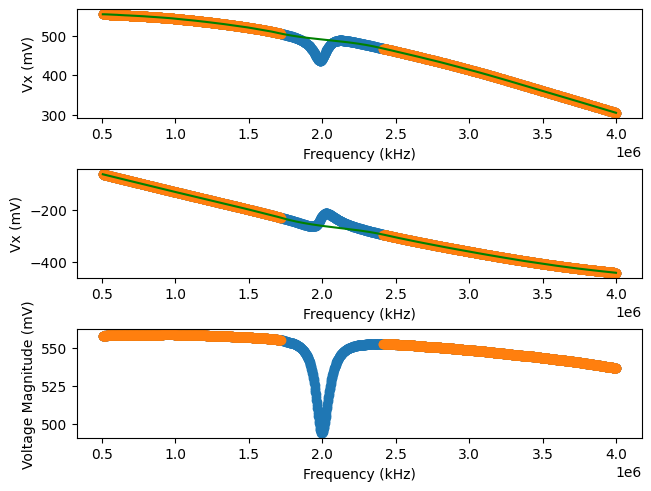

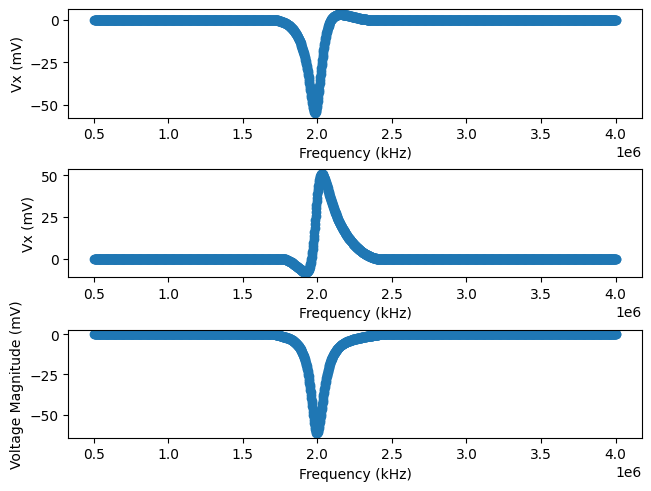

In [ ]:
fitted = {}
for dat in datas[2]:
    if dat != 'vamp':
        l = len(datas[2][dat])
        fitted[dat] = np.append(datas[2][dat][:int(l//2-250)] , datas[2][dat][int(l//2+75):])
    else:
        fitted[dat] = datas[2][dat]
# show_data(datas[2],fit_info = (False,bestpars1,False,bestpars2),filename='WideRange',show = True, mag_only = False)

inps = 2
if inps == 2:
    def vx_fit(freq,A,B):
        return A + B*freq 
    guesses3 = [fitted['vx'][0],1e-1]
    pbounds3 = np.array([[-1e3,-1],[1e3,1]]) # [[Lower bounds],[upper bounds]]
    guesses4 = [fitted['vy'][0],-1e-1]
    pbounds4 = np.array([[-1e3,-1],[1e3,1]]) # [[Lower bounds],[upper bounds]]
if inps == 3:
    def vx_fit(freq,A,B,C):
        return A + B*freq + C*freq**2
    guesses3 = [fitted['vx'][0],1e-1,0]
    pbounds3 = np.array([[-1e3,-1,-1],[1e3,1,1]]) # [[Lower bounds],[upper bounds]]
    guesses4 = [fitted['vy'][0],-1e-1,0]
    pbounds4 = np.array([[-1e3,-1,-1],[1e3,1,1]]) # [[Lower bounds],[upper bounds]]
elif inps ==4:
    def vx_fit(freq,A,B,C,D):
        return A + B*freq + C/(freq-D)
    guesses3 = [fitted['vx'][0],-1e-1,0,-2e6]
    pbounds3 = np.array([[-1e3,-1,-1,-1e7],[1e3,1,1,1e7]]) # [[Lower bounds],[upper bounds]]
    guesses4 = [fitted['vy'][0],-1e-1,0,0]
    pbounds4 = np.array([[-1e3,-1,-1,-1e7],[1e3,1,1,1e7]]) # [[Lower bounds],[upper bounds]]
elif inps == 5:
    def vx_fit(freq,A,B,C,D,E):
        return A + B*freq + C*(freq/100)**2 + D*(freq/100)**3 + E*(freq/100)**4
    guesses3 = [fitted['vx'][0],-1e-1,0,0,0]
    pbounds3 = np.array([[-1e3,-1,-1,-1,-1],[1e3,1,1,1,1]]) # [[Lower bounds],[upper bounds]]
    guesses4 = [fitted['vy'][0],-1e-1,0,0,0]
    pbounds4 = np.array([[-1e3,-1,-1,-1,-1],[1e3,1,1,1,1]]) # [[Lower bounds],[upper bounds]]

bestfit = optimize.curve_fit(vx_fit,datas[i]['freq'],datas[i]['vx'],guesses3, bounds=pbounds3)
bestpars3 = bestfit[0]
bestfit = optimize.curve_fit(vx_fit,datas[i]['freq'],datas[i]['vy'],guesses4, bounds=pbounds4)
bestpars4 = bestfit[0]
vy_background = vx_fit(fitted['freq'],*bestpars4)
vx_background = vx_fit(fitted['freq'],*bestpars3)
k = 3
vx_spline = interpolate.make_interp_spline(fitted['freq'],fitted['vx'],k=k)
vy_spline = interpolate.make_interp_spline(fitted['freq'],fitted['vy'],k=k)
vx_background = vx_spline(datas[2]['freq'])
vy_background = vy_spline(datas[2]['freq'])
vmag_background = np.sqrt(vx_background**2+vy_background**2)

print(bestpars3,bestpars4)
fig4 = plt.figure(constrained_layout = True)
ax1 = fig4.add_subplot(3, 1, 1)
ax2 = fig4.add_subplot(3, 1, 2)
ax3 = fig4.add_subplot(3, 1, 3)
ax1.set_xlabel('Frequency (kHz)')
ax2.set_xlabel('Frequency (kHz)')
ax3.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Vx (mV)')
ax2.set_ylabel('Vx (mV)')
ax3.set_ylabel('Voltage Magnitude (mV)')
ax1.scatter(datas[2]['freq'],datas[2]['vx'])
ax2.scatter(datas[2]['freq'],datas[2]['vy'])
ax3.scatter(datas[2]['freq'],datas[2]['vmag']*datas[2]['vamp'])
ax1.scatter(fitted['freq'],fitted['vx'])
ax2.scatter(fitted['freq'],fitted['vy'])
ax3.scatter(fitted['freq'],fitted['vmag']*fitted['vamp'])
ax1.plot(datas[2]['freq'],vx_background,c='green')
ax2.plot(datas[2]['freq'],vy_background,c='green')

fig5 = plt.figure(constrained_layout = True)
bx1 = fig5.add_subplot(3, 1, 1)
bx2 = fig5.add_subplot(3, 1, 2)
bx3 = fig5.add_subplot(3, 1, 3)
bx1.set_xlabel('Frequency (kHz)')
bx2.set_xlabel('Frequency (kHz)')
bx3.set_xlabel('Frequency (kHz)')
bx1.set_ylabel('Vx (mV)')
bx2.set_ylabel('Vx (mV)')
bx3.set_ylabel('Voltage Magnitude (mV)')
sub = True
if sub:
    bx1.scatter(datas[2]['freq'],datas[2]['vx']-np.interp(datas[2]['freq'],datas[2]['freq'],vx_background))
    bx2.scatter(datas[2]['freq'],datas[2]['vy']-np.interp(datas[2]['freq'],datas[2]['freq'],vy_background))
    bx3.scatter(datas[2]['freq'],datas[2]['vmag']*datas[2]['vamp']-np.interp(datas[2]['freq'],datas[2]['freq'],vmag_background))
else:
    bx1.scatter(datas[2]['freq'],datas[2]['vx'])
    bx2.scatter(datas[2]['freq'],datas[2]['vy'])
    bx3.scatter(datas[2]['freq'],datas[2]['vmag']*datas[2]['vamp'])

Center around res freq

In [ ]:
fig3 = plt.figure()
zx = fig3.add_subplot(1, 1, 1)
for i in range(len(datas)):
    # if i < 7 and i>0:
        # zx.scatter(datas[i]['freq'],datas[i]['vmag']*datas[i]['vamp'],label=filenames[i]+'Q='+str(int(fits[i][1])))
    if int(filenames[i][8])>4 and int(filenames[i][8])<8:
        zx.scatter(datas[i]['freq'],datas[i]['vmag'],label=filenames[i]+'Q='+str(int(fits[i][1])))
zx.legend()  
zx.set_xlabel('Frequency from resonance peak (kHz)')
zx.set_ylabel('Voltage Magnitude (mV)')
zx.set_xlim(2500,3500)
d = 20
zx.set_xlim(fits[0][0]-d,fits[0][0]+d)



TURNs plot

In [ ]:
fig4 = plt.figure(constrained_layout = True)
yx = fig4.add_subplot(1, 1, 1)
turns = []
peaks = []
for i in range(len(datas)):
    
    turns.append(datas[i]['turns'])
    peaks.append(fits[i][0])

# yx.legend()
sorted_turns,sorted_peaks = cosort_lists(turns,peaks)

yx.plot(sorted_turns,sorted_peaks,c='blue')
yx.set_xlabel('Turns ()')
yx.set_ylabel('Resoance Peak (kHz)')
d = 20
yx.set_xlim(fits[0][0]-d,fits[0][0]+d)
def line(x,a,b):
    return a + b*x
def linear_fit(x_data,y_data):
    y_dif = (y_data[-1]-y_data[0])
    x_dif = (x_data[-1]-x_data[0])
    slope = y_dif/x_dif
    guesses = [y_data[0]-slope*x_data[0],slope]
    print(guesses)
    bestfit = optimize.curve_fit(line,x_data,y_data,guesses)
    return bestfit[0]


def quad_fit(x_data,y_data):
    def quad(x,a,b,c):
        return c + b*x + a*x**2
    guesses3 = [fitted['vx'][0],1e-1,0]
    pbounds3 = np.array([[-1e3,-1,-1],[1e3,1,1]]) # [[Lower bounds],[upper bounds]]



NameError: name 'plt' is not defined

50 ohm temrinator stuff

In [ ]:

#
# fig6 = plt.figure(constrained_layout = True)
# cx1 = fig6.add_subplot(3, 1, 1)
# cx2 = fig6.add_subplot(3, 1, 2)
# cx3 = fig6.add_subplot(3, 1, 3)
# cx1.set_xlabel('Frequency (kHz)')
# cx2.set_xlabel('Frequency (kHz)')
# cx3.set_xlabel('Frequency (kHz)')
# cx1.set_ylabel('Vx (mV)')
# cx2.set_ylabel('Vx (mV)')
# cx3.set_ylabel('Voltage Magnitude (mV)')
# for i in range(3):
#     if np.abs(datas[i]['vx'][0])<300:
#         cx1.scatter(datas[i]['freq'],datas[i]['vx'])
#         cx2.scatter(datas[i]['freq'],datas[i]['vy'])
#         cx3.scatter(datas[i]['freq'],datas[i]['vmag']*datas[i]['vamp'])

# fig7 = plt.figure(constrained_layout = True)
# dx1 = fig7.add_subplot(3, 1, 1)
# dx2 = fig7.add_subplot(3, 1, 2)
# dx3 = fig7.add_subplot(3, 1, 3)
# dx1.set_xlabel('Frequency (kHz)')
# dx2.set_xlabel('Frequency (kHz)')
# dx3.set_xlabel('Frequency (kHz)')
# dx1.set_ylabel('Vx (mV)')
# dx2.set_ylabel('Vx (mV)')
# dx3.set_ylabel('Voltage Magnitude (mV)')
# for i in range(3):
#     if np.abs(datas[i]['vx'][0])>300:
#         dx1.scatter(datas[i]['freq'],datas[i]['vx'])
#         fit = np.polyfit(datas[i]['freq'],datas[i]['vx'],2)
#         dx1.plot(datas[i]['freq'],plot_polyfit(datas[i]['freq'],fit),c='red')
#         dx2.scatter(datas[i]['freq'],datas[i]['vy'])
#         fit = np.polyfit(datas[i]['freq'],datas[i]['vy'],1)
#         dx2.plot(datas[i]['freq'],plot_polyfit(datas[i]['freq'],fit),c='red')
#         print(fit)
#         # fit = linear_fit(datas[i]['freq'],datas[i]['vy'])
#         # print(fit)
#         # dx2.plot(datas[i]['freq'],line(datas[i]['freq'],*fit),c='red')
#         # dx2.scatter(datas[i]['freq'],datas[i]['vy']-line(datas[i]['freq'],*fit))
#         dx3.scatter(datas[i]['freq'],datas[i]['vmag']*datas[i]['vamp'])